In [1]:
import torchvision
import numpy as np
import random
import torch.utils.data as Data
import torch
import torch.nn as nn
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

### Dataset pre-processing and feature extraction

In [2]:
# get dataset from torchvision
MNIST_image_data=torchvision.datasets.MNIST(root='./mnist/',train=True,transform=torchvision.transforms.ToTensor(),download=True)
# test_data=torchvision.datasets.MNIST(root='./mnist/',train=False,transform=torchvision.transforms.ToTensor(),download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST\raw\train-images-idx3-ubyte.gz to ./mnist/MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST\raw\train-labels-idx1-ubyte.gz to ./mnist/MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST\raw\t10k-images-idx3-ubyte.gz to ./mnist/MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./mnist/MNIST\raw



In [3]:
# get images of the number 0 and 7 for train data and test data 
image_0=[]
image_7=[]

for k in range(len(MNIST_image_data)):
    if MNIST_image_data[k][1]==0:
        image_0.append(MNIST_image_data[k][0])
    elif MNIST_image_data[k][1]==7:
        image_7.append(MNIST_image_data[k][0])
        

train_image_0=image_0[:5000]
train_image_7=image_7[:5000]
test_image_0=image_0[5000:]
test_image_7=image_7[5000:]


In [4]:
len(train_image_0),len(train_image_7),len(test_image_0),len(test_image_7)

(5000, 5000, 923, 1265)

In [5]:
# Randomly select N images of number 0 and (100-N) images of number 7 into a bag
# Record the proportion of the images of the number 0

# 20000 bags for training
bag_num=20000
bags_list=[]
labels_list=[]

for j in range(bag_num):
    if (j%3==0):
        random_zero_num=0
    else:
        random_zero_num=np.random.randint(0,100)   # generate random number between 0 and 100
    x=random_zero_num/100                          # compute the proportion
    bag=torch.squeeze(torch.stack(random.sample(train_image_0,random_zero_num)+random.sample(train_image_7,100-random_zero_num))).numpy()
    bags_list.append(bag)
    labels_list.append(x)
    
    
# 2000 bags for testing
test_bag_num=2000
test_bags_list=[]
test_labels_list=[]

for j in range(test_bag_num):
    if (j%3==0):
        random_zero_num=0
    else:
        random_zero_num=np.random.randint(0,100)   # generate random number between 0 and 100
    x=random_zero_num/100                          # compute the proportion
    bag=torch.squeeze(torch.stack(random.sample(test_image_0,random_zero_num)+random.sample(test_image_7,100-random_zero_num))).numpy()
    test_bags_list.append(bag)
    test_labels_list.append(x)

In [6]:
# Transform list in Tensor
bags=torch.from_numpy(np.array(bags_list))
labels=torch.from_numpy(np.array(labels_list))
test_bags=torch.from_numpy(np.array(test_bags_list))
test_labels=torch.from_numpy(np.array(test_labels_list))

# Transform image tensor and labels into the type of TensorDataset, load dataset into Dataloader and set batch size to 64
labeled_dataset= Data.TensorDataset(bags,labels)
train_data_loader= Data.DataLoader(dataset=labeled_dataset,batch_size=64,shuffle=True)
test_dataset= Data.TensorDataset(test_bags,test_labels)
test_data_loader= Data.DataLoader(dataset=test_dataset,batch_size=64,shuffle=True)

### The construction of the pooling layer and the bag-level representation transformer in multi-layer-perceptron of neural network 

In [7]:
# network construction
# parameters
pooling_kernel_size=3
first_in, first_out, second_out ,third_out= 100*pow(int((28+3-pooling_kernel_size)/pooling_kernel_size),2),900,100,1



class RepresentationTransformation(nn.Module):
    def __init__(self):
        super(RepresentationTransformation, self).__init__()
        self.fc1 = nn.Linear(first_in,first_out)
        self.fc2 = nn.Linear(first_out,second_out)
        self.fc3 = nn.Linear(second_out,third_out)
        
    def forward(self,din):
        dout1 = nn.functional.relu(self.fc1(din))
        dout2 = nn.functional.relu(self.fc2(dout1))
        return nn.functional.relu(self.fc3(dout2))
    
        

class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.pooling=nn.MaxPool2d(kernel_size=3,padding=0)
        self._representation_transformation = RepresentationTransformation()
        
    def forward(self,din):
        dout1 = self.pooling(din)
        dout2 = dout1.view(-1,first_in)
        dout3 = self._representation_transformation(dout2)

        return dout3

In [8]:
model=MLP()
device=torch.device('cpu')
model.to(device)

MLP(
  (pooling): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (_representation_transformation): RepresentationTransformation(
    (fc1): Linear(in_features=8100, out_features=900, bias=True)
    (fc2): Linear(in_features=900, out_features=100, bias=True)
    (fc3): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [9]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0002,weight_decay = 0.0005)
# define loss criterion
criterion = torch.nn.L1Loss()

In [10]:
for x in range(5):
    
    for i,data in enumerate(train_data_loader):
        outputs_list=[]
        labels_list=[]
        optimizer.zero_grad()
    
        (inputs,labels) = data
        inputs = torch.autograd.Variable(inputs)
        labels = torch.autograd.Variable(labels)
    
        outputs = model(inputs)
        outputs = outputs.squeeze(-1)
    
        loss = criterion(outputs,labels)
        loss.backward()
    
        optimizer.step()
    
        outputs_list+=outputs.tolist()
        labels_list+=labels.tolist()
        if (i%50==0):   
            print('Epoch '+str(x) + ' step '+str(i) + " : R_Squared is ", r2_score(labels_list,outputs_list))

Epoch 0 step 0 : R_Squared is  -1.096567178276782
Epoch 0 step 50 : R_Squared is  0.9776099275129032
Epoch 0 step 100 : R_Squared is  0.9932247998683665
Epoch 0 step 150 : R_Squared is  0.9966412709727632
Epoch 0 step 200 : R_Squared is  0.9968704174201936
Epoch 0 step 250 : R_Squared is  0.9967660914928942
Epoch 0 step 300 : R_Squared is  0.9982002957214258
Epoch 1 step 0 : R_Squared is  0.9924670389261754
Epoch 1 step 50 : R_Squared is  0.9971082258580813
Epoch 1 step 100 : R_Squared is  0.996464490409427
Epoch 1 step 150 : R_Squared is  0.9981586152995032
Epoch 1 step 200 : R_Squared is  0.995666005351727
Epoch 1 step 250 : R_Squared is  0.9979890921502234
Epoch 1 step 300 : R_Squared is  0.9984088494847194
Epoch 2 step 0 : R_Squared is  0.9982477839452037
Epoch 2 step 50 : R_Squared is  0.9986946424530562
Epoch 2 step 100 : R_Squared is  0.998942612234396
Epoch 2 step 150 : R_Squared is  0.9972590385154629
Epoch 2 step 200 : R_Squared is  0.998675214594614
Epoch 2 step 250 : R_Squa

In [11]:
test_output=[]
test_labels=[]
for i,data in enumerate(test_data_loader):
        (inputs,labels) = data
        outputs = model(inputs)
        outputs = outputs.squeeze(-1)
        test_output+=outputs.tolist()
        test_labels+=labels.tolist()

In [12]:
R2=r2_score(test_labels,test_output)
R2

0.9954387332388036

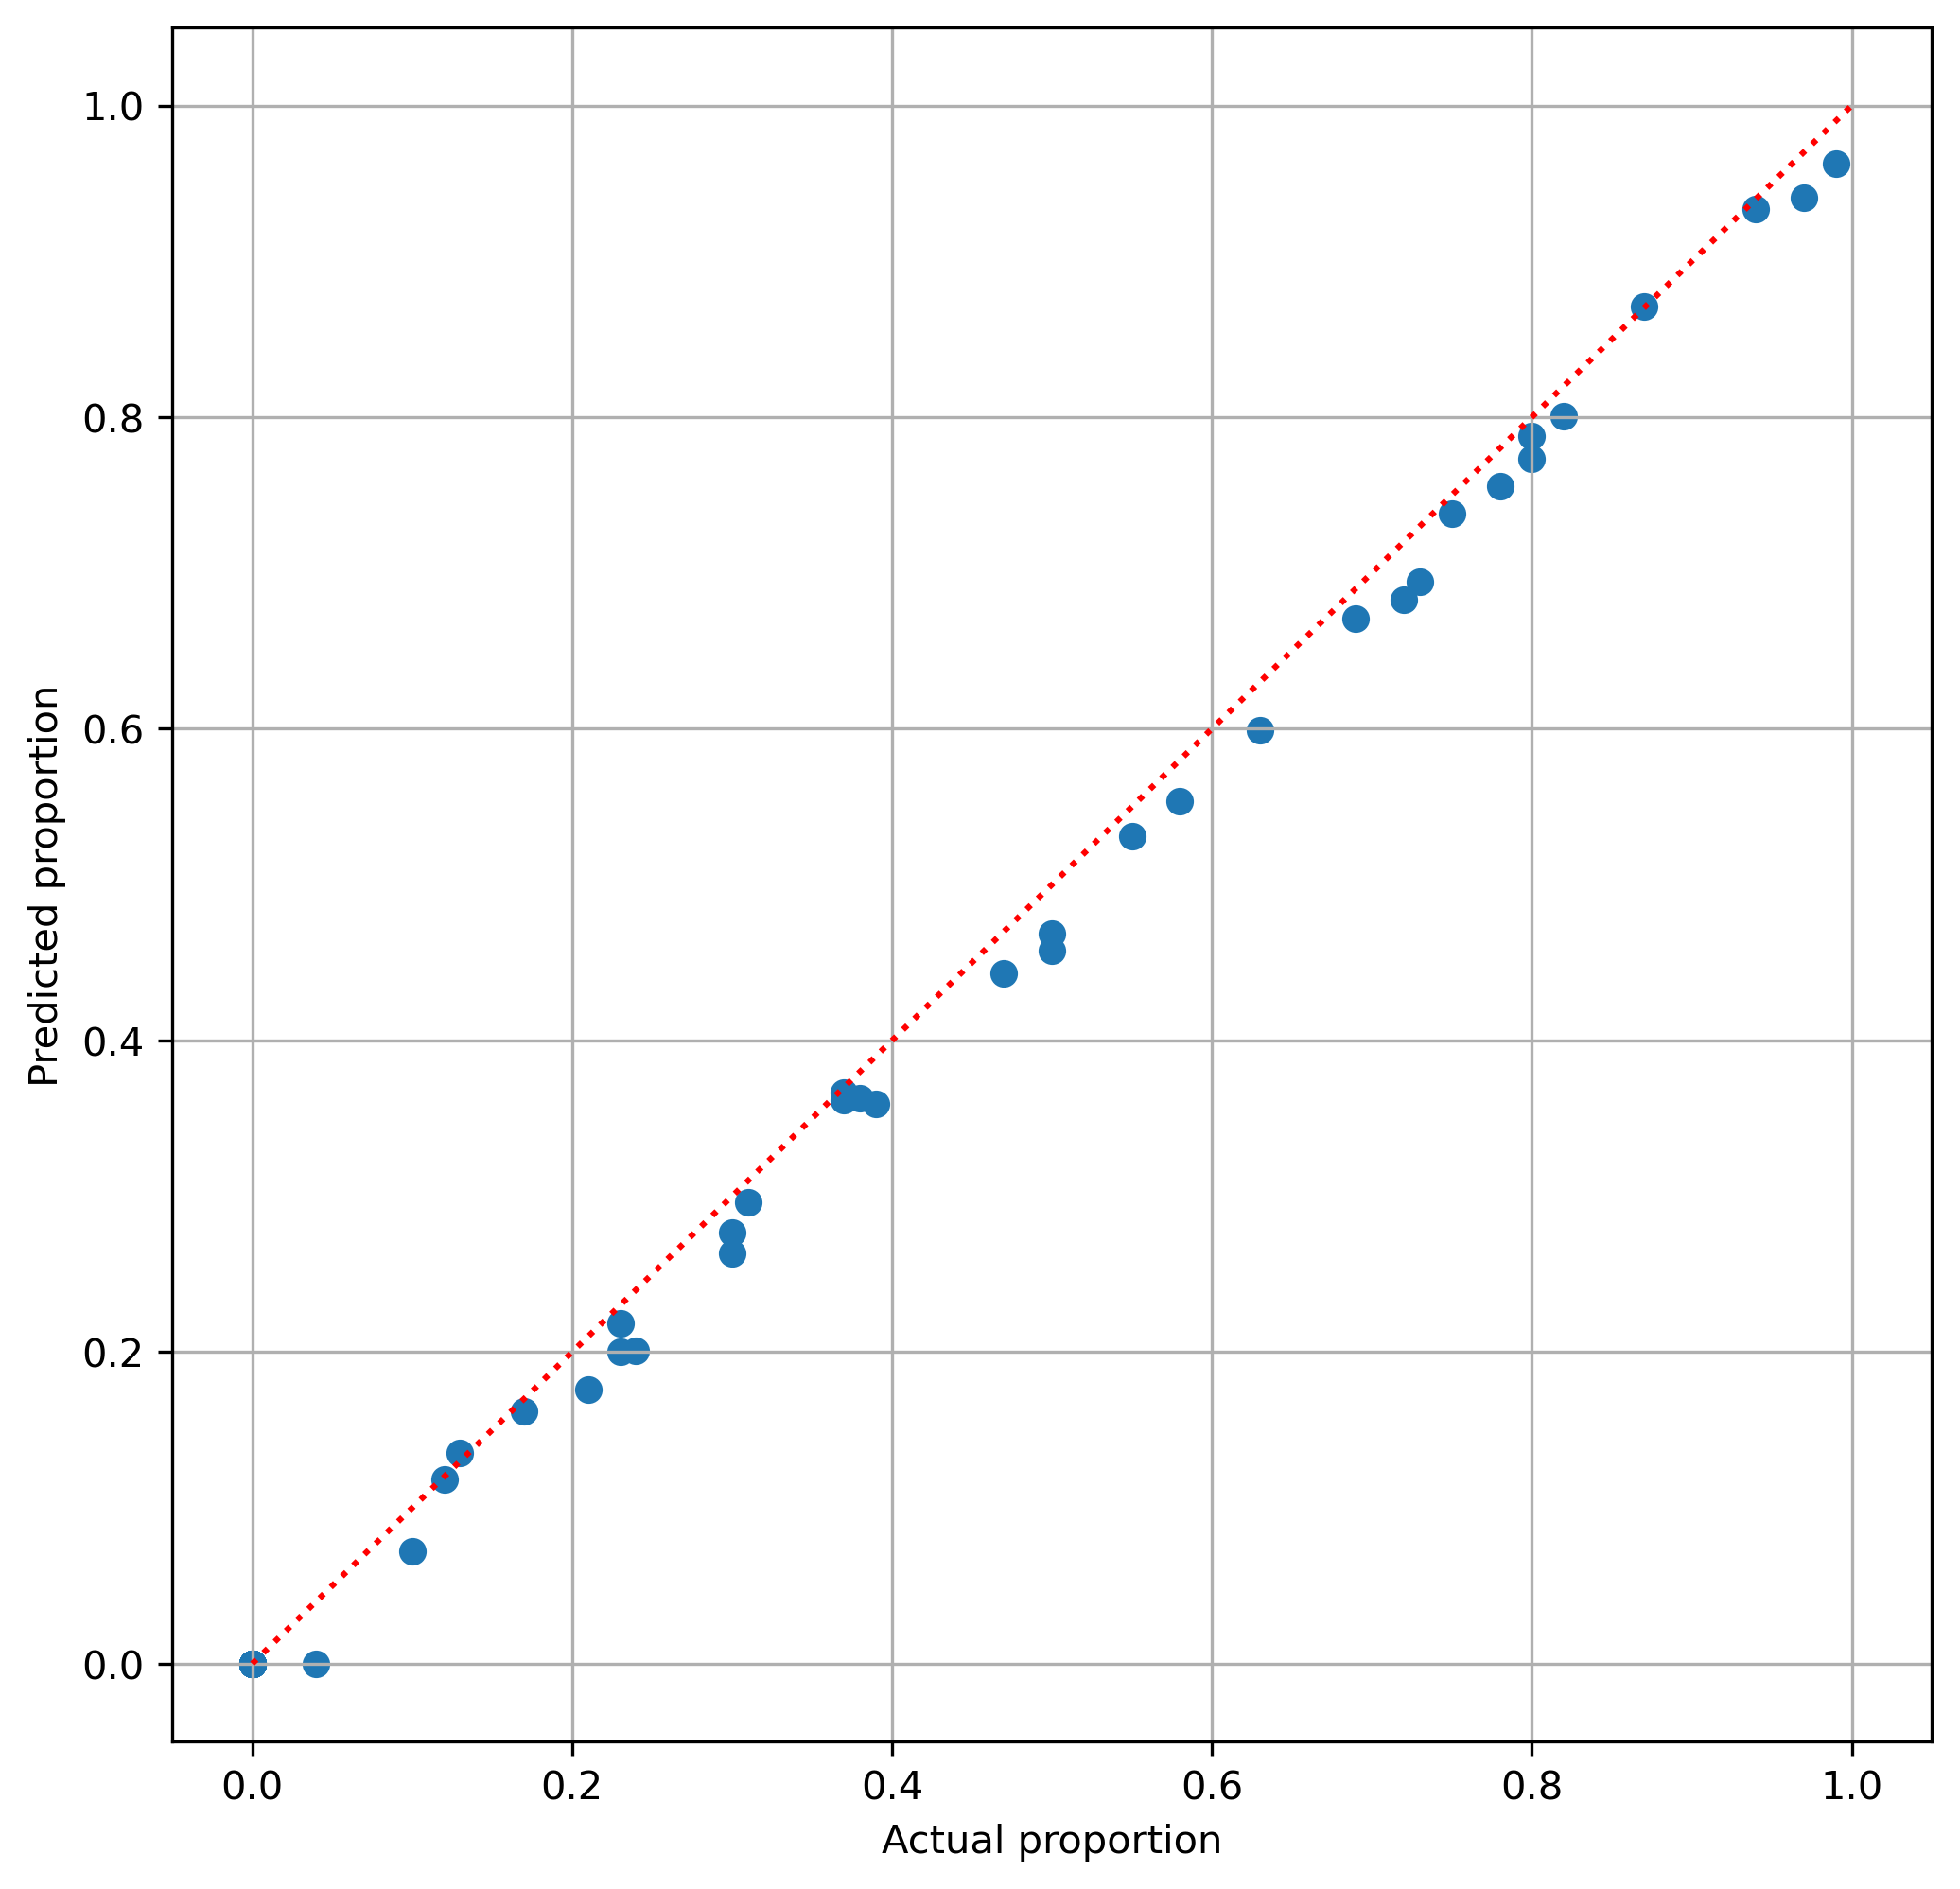

In [13]:
plt.figure(figsize=(8,8),dpi=300)
plt.scatter(x=test_labels[0:50], y=test_output[0:50])
plt.plot(np.array([0,1]), color = 'r', linestyle = 'dotted')
plt.xlabel('Actual proportion')
plt.ylabel('Predicted proportion')

plt.grid()
plt.show()

In [14]:
# save model
torch.save(model,"model_20000bags.pt")

In [ ]:
# load model
model=torch.load("model_20000bags.pt")